SCHOOL OF COMPUTER SCIENCE AND ENGINEERING, UNIVERSITY OF NEW SOUTH WALES

COMP9417 - MACHINE LEARNING

# DOG - CAT PREDICTION MODELS

Written by Group 193

Member: Vien Dat Huynh - z5223470

Tutored by Omar Ghattas

# Project Overview

This machine learning project is developed for dog and cat classification. The dataset is available from Kaggle Competition

https://www.kaggle.com/c/dogs-vs-cats 

which contains 12,500 dog images, 12,500 cat images and 12,500 unlabeled images. Due to the time limit of the project, only the labeled dataset is utilised to train and test the machine learning models. A couple of unknown samples will be manually tested for tester's observation.

This project involves in two different machine learning models: Logistic Regression and Convolutional Neural Network. TensorFlow is used to process the image dataset and labels. Then they will be tested and analysed with various image resolutions and data amounts.

# Environment Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

In [2]:
# This project requires TensorFlow 2.2.0 or later
# It is recommended that TensorFlow and Keras should be upgraded to the latest version
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.3.0


In [3]:
# Keras 2.2.0 or later
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
print('Keras version:', tf.__version__)
print('keras using %s backend'%keras.backend.backend())

import matplotlib.pyplot as graph
%matplotlib inline
graph.rcParams['figure.figsize'] = (15,5)
graph.rcParams["font.family"] = 'DejaVu Sans'
graph.rcParams["font.size"] = '12'
graph.rcParams['image.cmap'] = 'rainbow'

Keras version: 2.3.0
keras using tensorflow backend


In [4]:
# IPython module for processing and displaying images
import IPython.display as display
from PIL import Image
import os
import pathlib

# Dataset Review

In [5]:
# Show number of images from folder 'train' and 'test1' in the dataset 'dogs-vs-cats'
data_dir = pathlib.Path('dogs-vs-cats')
dog_count = len(list(data_dir.glob('train/dog.*')))
cat_count = len(list(data_dir.glob('train/cat.*')))
unlabeled_count = len(list(data_dir.glob('test1/*')))
print('Number of dog images:', dog_count)
print('Number of cat images:', cat_count)
print('Number of unlabeled images:', unlabeled_count)

Number of dog images: 12500
Number of cat images: 12500
Number of unlabeled images: 12500


# Directory Dataset

In [6]:
# Create a dataset of image paths to folder 'train' for train and test set
# As 
dataset_dir = tf.data.Dataset.list_files(str(data_dir/'train/*.jpg'), 10)
print('Number of labeled samples: ', len(list(dataset_dir)))

# Similarly, create a dataset of paths to folder 'test1' for manual testing
predict_dir = tf.data.Dataset.list_files(str(data_dir/'test1/*.jpg'), 10)
print('Number of unlabeled samples: ', len(list(predict_dir)))

Number of labeled samples:  25000
Number of unlabeled samples:  12500


# Image Setting

In [7]:
# As the dataset is quite large, a variable is setup 
# to control the number of images pulled out from the directory dataset
# Modify its value in range [100, 25000] based on the training and testing purpose
DATASET_SIZE = 1000
# Setup dataset size for training Regression model
# REGRESSION_DATASET <= DATASET_SIZE
REGRESSION_DATASET = 200
# Setup the number of unlabeled images for manually checking
# UNLABELED_CHECK_SAMPLES <= 25,0000
UNLABELED_CHECK_SAMPLES = 3
# Setup dataset size for evaluating activation functions/optimizers
# EVALUATE_SAMPLES <= DATASET_SIZE
EVALUATE_SAMPLES = 100

# Setup the image resolution. 50x50 - 100x100 is recommended,
# everything above 200x200 will result in a significant amount of training time or even kernel's death
IMG_HEIGHT = 50
IMG_WIDTH = 50

# Create Train & Test Dataset

In [8]:
# Count the number of dogs and cats
dog_samples = 0
cat_samples = 0

# Return label of a given image based on its name (0: Dog, 1: Cat)
def label_image(path):
    global dog_samples
    global cat_samples
    
    # Split the given path into a list of folders
    parts = str(path).split(os.path.sep)
    # Get the image name
    img_name = parts[-1].rstrip("'")
    # Classify the image by name
    if 'dog' in img_name:
        dog_samples += 1
        return 0
    else:
        cat_samples += 1
        return 1

In [9]:
# Return a TensorFlow image and label given its file path
def process_path(path):
    # Load image from the path
    img = tf.io.read_file(path)
    # Convert it into TensorFlow object
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize image
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # Get image label
    label = tf.numpy_function(func=label_image, inp=[path], Tout=tf.int64)
    return img, label

In [10]:
# Create dataset containing images and their labels
dataset = dataset_dir.map(process_path)
# Process the images of unlabeled dataset but we do not use the returned labels
predict_set = predict_dir.map(process_path)

In [11]:
# Prepare dataset for training and testing
def prepare_dataset(dataset, batch_size=DATASET_SIZE, cache=True, shuffle_buffer_size=52):
    # Use cache() to cache preprocessing work for datasets
    if cache:
        if isinstance(cache, str):
            dataset = dataset.cache(cache)
        else:
            dataset = dataset.cache()

    dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    return dataset

In [12]:
# Prepare DATASET_SIZE samples of dataset
dataset = prepare_dataset(dataset, DATASET_SIZE)
# Prepare UNLABELED_CHECK_SAMPLES samples of unlabeled dataset
predict_set = prepare_dataset(predict_set, UNLABELED_CHECK_SAMPLES)
# Split the dataset into image set and label set
dataset_X, dataset_Y = next(iter(dataset))
# Similar with unlabeled dataset but only predict_X will be used
predict_X, predict_Y = next(iter(predict_set))

In [13]:
# Display photos with label 'Dog'/'Cat'
def preview_img_label(images, labels):
    graph.figure(figsize=(8, 8))
    for i in range(16):
        ax = graph.subplot(4, 4, i+1)
        graph.imshow(images[i], cmap='gray', interpolation='nearest')
        if labels[i] == 0:
            graph.title(str(labels[i].numpy())+' - Dog')
        else:
            graph.title(str(labels[i].numpy())+' - Cat')
        graph.axis('off')

Number of dog images:  562
NUmber of cat images:  543


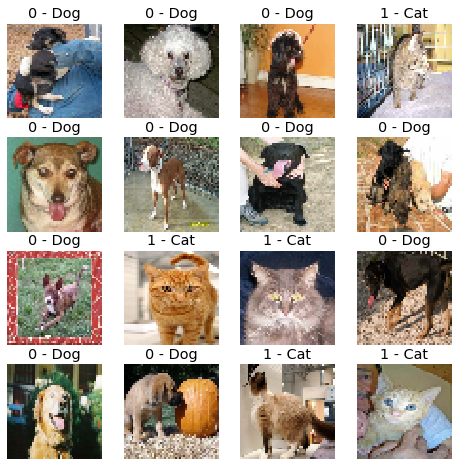

In [14]:
# Preview dataset for training and testing
print('Number of dog images: ', dog_samples)
print('NUmber of cat images: ', cat_samples)
preview_img_label(dataset_X.numpy(), dataset_Y)

In [15]:
# Convert images to grayscale (1 dimension)
dataset_X = tf.image.rgb_to_grayscale(dataset_X)
# Convert the image dataset to Numpy array for training models
dataset_X = np.array(dataset_X)

In [16]:
# Split the dataset into train, validation and test sets
# The Convolutional Neural Network model will be trained and tested with this set
# 10% for testing
test_split = int(dataset_X.shape[0] * 90 // 100)

# 18% for validation
valid_split = int(test_split * 80 // 100)

train_X = dataset_X[:valid_split]
train_Y = dataset_Y[:valid_split]
valid_X = dataset_X[valid_split:test_split]
valid_Y = dataset_Y[valid_split:test_split]
test_X = dataset_X[test_split:]
test_Y = dataset_Y[test_split:]

print('Number of samples for training:', train_X.shape[0])
print('Number of samples for validation:', valid_X.shape[0])
print('Number of samples for testing:', test_X.shape[0])

Number of samples for training: 720
Number of samples for validation: 180
Number of samples for testing: 100


In [17]:
# Duplicate and reshape dataset into flatten images
# for fitting Logistic Regression model
flatten_train_X = np.reshape(train_X, (train_X.shape[0], IMG_HEIGHT*IMG_WIDTH), order='C')
flatten_train_Y = np.reshape(train_Y, (train_Y.shape[0], 1), order='C')
flatten_test_X = np.reshape(test_X, (test_X.shape[0], IMG_HEIGHT*IMG_WIDTH), order='C')
flatten_test_Y = np.reshape(test_Y, (test_Y.shape[0], 1), order='C')

In [18]:
# Convert labels to One Hot vectors for training CNN model 
# Dog: [1. 0.] and Cat: [0. 1.]
train_Y = keras.utils.to_categorical(train_Y, 2)
valid_Y = keras.utils.to_categorical(valid_Y, 2)
test_Y = keras.utils.to_categorical(test_Y, 2)

print('First label in training set:', train_Y[0])
print('First label in validation set:', valid_Y[0])
print('First label in testing set:', test_Y[0])

First label in training set: [1. 0.]
First label in validation set: [1. 0.]
First label in testing set: [0. 1.]


# Logistic Regression

In [19]:
# Create a logistic regression model using sklearn
from sklearn.linear_model import LogisticRegression
regression_model = LogisticRegression(random_state=42, verbose=True)
print('Logistic Regression Model created')
# Fit the model with flattened dataset
regression_model.fit(flatten_train_X[:REGRESSION_DATASET], flatten_train_Y[:REGRESSION_DATASET])
print('Logistic Regression Model fitted')

Logistic Regression Model created
Logistic Regression Model fitted


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [20]:
# Calculate its accuracy with train dataset
regression_train_accuracy = regression_model.score(flatten_train_X[:REGRESSION_DATASET], flatten_train_Y[:REGRESSION_DATASET])
print('>>> Train Set Accuracy: ', str(regression_train_accuracy*100)+'%')
# Evaluate its accuracy with test dataset
regression_test_accuracy = regression_model.score(flatten_test_X[:int(REGRESSION_DATASET/10)], flatten_test_Y[:int(REGRESSION_DATASET/10)])
print('>>> Test Set Accuracy:', str(regression_test_accuracy*100)+'%')

>>> Train Set Accuracy:  100.0%
>>> Test Set Accuracy: 65.0%


>>> Probability of Cat: 49.83393969668456%
>>> Prediction: Dog


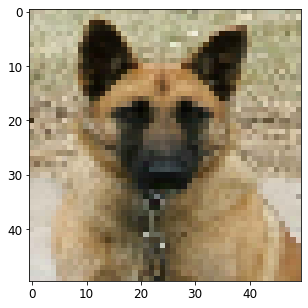

>>> Probability of Cat: 13.772320034119378%
>>> Prediction: Dog


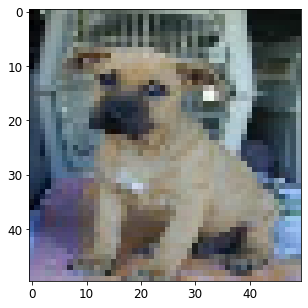

>>> Probability of Cat: 58.88553374232169%
>>> Prediction: Cat


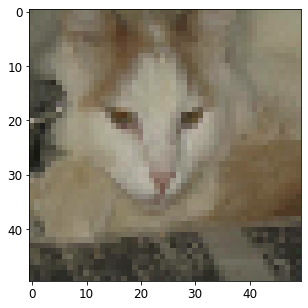

In [21]:
# Manual test using unlabeled dataset
for i in range(UNLABELED_CHECK_SAMPLES):
    # Process the image
    sample = tf.image.rgb_to_grayscale(predict_X[i])
    sample = np.reshape(sample, (1, IMG_HEIGHT*IMG_WIDTH), order='C')
    # Calculate and print the probability of cat image ranging [0, 1]
    probOfCat = regression_model.predict_proba(sample)[0][1]
    print(">>> Probability of Cat:", str(probOfCat*100) + "%")
    # Predict cat or dog based on the probability
    # probOfCat >= 0.5: Cat, probOfCat < 0.5: Dog
    prediction = regression_model.predict(sample)
    if prediction == 0:
        print('>>> Prediction: Dog')
    else:
        print('>>> Prediction: Cat')
    # Display the unlabeled image
    graph.imshow(predict_X[i], cmap='gray', interpolation='nearest')
    graph.show()

# Convolutional Neural Network

EVALUATE ACTIVATION FUNCTION AND OPTIMISER

In [22]:
# Return training statistics and fitted CNN model given activation and optimiser
def train_CNN(activation, optimizer, epochs):
    # Create a sequential CNN model
    np.random.seed(5)
    model = Sequential()
    # Add hidden layers
    model.add(Conv2D(16, kernel_size=(3, 3), activation=activation, input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
    model.add(Conv2D(32, (3, 3), activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.125))
    model.add(Flatten())
    model.add(Dense(32, activation=activation))
    model.add(Dropout(0.25))
    # Add output layer
    model.add(Dense(2, activation=tf.nn.softmax))
    # Compile model with given optimiser
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # Train model
    print('in training... ', end='')
    training_stats = model.fit(train_X[:EVALUATE_SAMPLES], train_Y[:EVALUATE_SAMPLES], epochs=epochs, verbose=0, validation_data=(valid_X, valid_Y))
    # Show the statistics of training process
    print('train accuracy: %0.3f, test accuracy: %0.3f' %(training_stats.history['accuracy'][-1], model.evaluate(test_X, test_Y, verbose=0)[1]))
    return training_stats, model

In [23]:
# Plot barchart comparing the accuracy of given activation functions/optimisers
def bar_chart(train_acc, test_acc, title, functions):
    i = range(1, train_acc.shape[0] + 1)
    # Plots the training and testing accuracy bars
    training_accuracy = graph.bar(i, train_acc, 0.4, align = 'center')
    testing_accuracy = graph.bar(i, test_acc, 0.4, align = 'edge')
    graph.legend((training_accuracy[0], testing_accuracy[0]), ('Training Accuracy', 'Testing Accuracy'))
    graph.xticks(i, functions)
    graph.title(title)
    graph.show()

Evaluating model with elu activation function >>> in training... train accuracy: 0.640, test accuracy: 0.470
Evaluating model with selu activation function >>> in training... train accuracy: 0.840, test accuracy: 0.460
Evaluating model with relu activation function >>> in training... train accuracy: 0.520, test accuracy: 0.470
Evaluating model with tanh activation function >>> in training... train accuracy: 0.700, test accuracy: 0.440
Evaluating model with sigmoid activation function >>> in training... train accuracy: 0.460, test accuracy: 0.480
Evaluating model with hard_sigmoid activation function >>> in training... train accuracy: 0.520, test accuracy: 0.480
Evaluating model with softplus activation function >>> in training... train accuracy: 0.600, test accuracy: 0.480
Evaluating model with softsign activation function >>> in training... train accuracy: 0.600, test accuracy: 0.500
Evaluating model with linear activation function >>> in training... train accuracy: 0.820, test accura

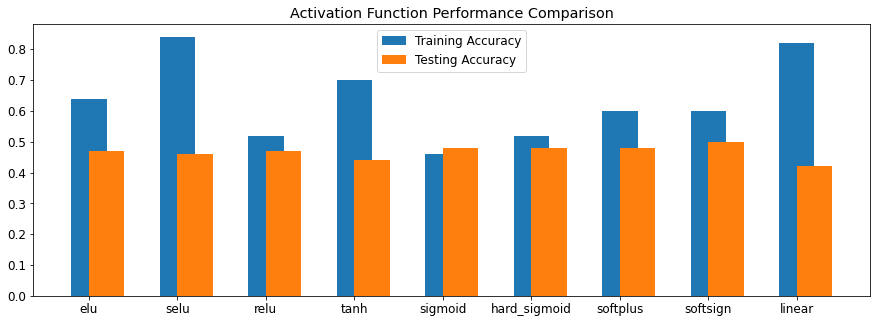

In [24]:
# Numpy lists storing train statistics
train_accuracy = np.empty((0))
test_acccuracy = np.empty((0))

# Create list of activation functions
activation_functions = ['elu', 'selu', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'softplus', 'softsign', 'linear']
for activation in activation_functions:
    print('Evaluating model with %s activation function >>> ' %activation, end='')
    training_stats, model = train_CNN(activation=activation, optimizer='SGD', epochs=5)
    train_accuracy = np.append(train_accuracy, training_stats.history['accuracy'][-1])
    test_acccuracy = np.append(test_acccuracy, model.evaluate(test_X, test_Y, verbose=0)[1])
    
# Plot bar chart comparing activation functions
bar_chart(train_accuracy, test_acccuracy, 'Activation Function Performance Comparison', activation_functions)

Evaluating model with SGD optimizer >>> in training... train accuracy: 0.620, test accuracy: 0.490
Evaluating model with RMSprop optimizer >>> in training... train accuracy: 0.900, test accuracy: 0.480
Evaluating model with Adagrad optimizer >>> in training... train accuracy: 0.560, test accuracy: 0.470
Evaluating model with Adadelta optimizer >>> in training... train accuracy: 0.440, test accuracy: 0.510
Evaluating model with Adam optimizer >>> in training... train accuracy: 0.900, test accuracy: 0.470
Evaluating model with Adamax optimizer >>> in training... train accuracy: 0.840, test accuracy: 0.450
Evaluating model with Nadam optimizer >>> in training... train accuracy: 0.860, test accuracy: 0.470


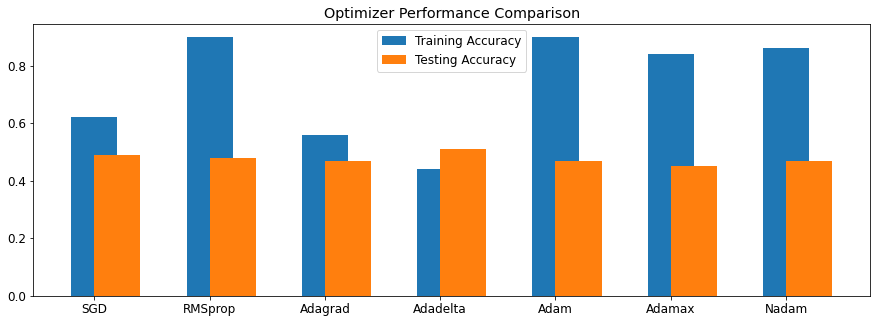

In [25]:
# Numpy lists storing train statistics
train_accuracy = np.empty((0))
test_acccuracy = np.empty((0))

# Create list of optimizers
optimization_functions = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
for optimizer in optimization_functions:
    print('Evaluating model with %s optimizer >>> ' %optimizer, end='')
    training_stats, model = train_CNN(activation='relu', optimizer=optimizer, epochs=5)
    train_accuracy = np.append(train_accuracy, training_stats.history['accuracy'][-1])
    test_acccuracy = np.append(test_acccuracy, model.evaluate(test_X, test_Y, verbose=0)[1])
    
# Plot bar chart comparing optimizers
bar_chart(train_accuracy, test_acccuracy, 'Optimizer Performance Comparison', optimization_functions)

BUILD A CNN MODEL

In [26]:
# Initialise a Sequential model
np.random.seed(5)
cnn_model = Sequential()

In [27]:
# Setup pre-processing layer of the network with kernel size of (3, 3)
cnn_model.add(Conv2D(16, kernel_size = (3, 3), activation='selu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
cnn_model.add(Conv2D(32, (3, 3), activation='selu'))
# Add pooling layers for downsampling data and reducing training time
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
# Add Dropout to prevent overfitting
cnn_model.add(Dropout(0.125))
cnn_model.add(Flatten())
# Add Dense layer to perform classification based on features gathered by the pre-processing layers
cnn_model.add(Dense(32, activation='selu'))
cnn_model.add(Dropout(0.25))
# Softmax is the most effective for classification
# Add Softmax layers to out the probability for 2 categories
cnn_model.add(Dense(2, activation=tf.nn.softmax))
# Compile model with the optimizer 'Adam'
cnn_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

TRAIN AND TEST

In [28]:
# Fit the model with train and validation datasets
training_stats = cnn_model.fit(train_X, train_Y, epochs=10, verbose=1, validation_data=(valid_X, valid_Y))

Epoch 1/10
23/23 [==============================] - 2s 80ms/step - loss: 1.7987 - accuracy: 0.5208 - val_loss: 0.7148 - val_accuracy: 0.4667
Epoch 2/10
23/23 [==============================] - 2s 69ms/step - loss: 0.9913 - accuracy: 0.5042 - val_loss: 0.7107 - val_accuracy: 0.6056
Epoch 3/10
23/23 [==============================] - 2s 86ms/step - loss: 0.7402 - accuracy: 0.5986 - val_loss: 0.7220 - val_accuracy: 0.6056
Epoch 4/10
23/23 [==============================] - 2s 81ms/step - loss: 0.5102 - accuracy: 0.7431 - val_loss: 0.7409 - val_accuracy: 0.6000
Epoch 5/10
23/23 [==============================] - 2s 82ms/step - loss: 0.4376 - accuracy: 0.8083 - val_loss: 0.7698 - val_accuracy: 0.5556
Epoch 6/10
23/23 [==============================] - 2s 70ms/step - loss: 0.3299 - accuracy: 0.8611 - val_loss: 0.8010 - val_accuracy: 0.5389
Epoch 7/10
23/23 [==============================] - 1s 65ms/step - loss: 0.2718 - accuracy: 0.9069 - val_loss: 0.8965 - val_accuracy: 0.5389
Epoch 8/10
23

Test Set Evaluation: loss = 1.348800, accuracy = 52.00


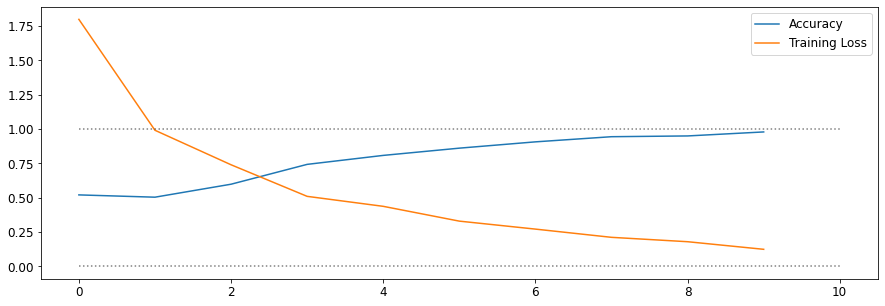

In [29]:
# Evaluate the model with the test dataset
cnn_evaluation = cnn_model.evaluate(test_X, test_Y, verbose=0)

# Print the loss data and model's performance on the test set
print('Test Set Evaluation: loss = %0.6f, accuracy = %0.2f' %(cnn_evaluation[0], 100*cnn_evaluation[1]))

# Plot statistics of training process
accuracy, = graph.plot(training_stats.history['accuracy'], label='Accuracy')
training_loss, = graph.plot(training_stats.history['loss'], label='Training Loss')
graph.legend(handles = [accuracy, training_loss])
loss = np.array(training_stats.history['loss'])
xp = np.linspace(0,loss.shape[0],10*loss.shape[0])
graph.plot(xp, np.full(xp.shape, 1), c='k', linestyle=':', alpha=0.5)
graph.plot(xp, np.full(xp.shape, 0), c='k', linestyle=':', alpha=0.5)
graph.show()

Prediction: Dog


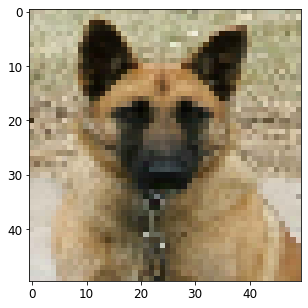

Prediction: Cat


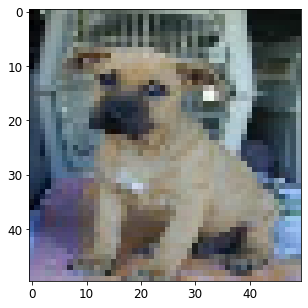

Prediction: Cat


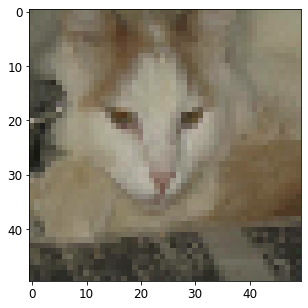

In [30]:
###### Manual test using unlabeled dataset
for i in range(UNLABELED_CHECK_SAMPLES):
    # Process the image
    sample = tf.image.rgb_to_grayscale(predict_X[i])
    sample = np.array(sample)
    # Predict cat or dog based on the probability
    prediction = cnn_model.predict(sample.reshape(1, IMG_HEIGHT, IMG_WIDTH, 1))
    if np.argmax(prediction) == 0:
        print('Prediction: Dog')
    else:
        print('Prediction: Cat')
    # Display the unlabeled image
    graph.imshow(predict_X[i], cmap='gray', interpolation='nearest')
    graph.show()